In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Fisher_CMB import *
from Models.SPT3G.spt3G_model import spt3G_model
from Models.Planck.Planck_model import planck_model
from pickle import load as pload
from pickle import dump
from Covariances.create_basic_cov import *
import pandas as pd
import cosmoslik as K

# Make Fisher Matrices and Save 

##  LCDM Fisher Matrices

In [122]:
params={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           #'nnu':fish_param(3.046,0.03),
                           #'YHe':fish_param(.252,.014),
                           'lmax':6000,'lens_potential_accuracy':5.0}

In [5]:
params3g={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           #'nnu':fish_param(3.046,0.03),
                           #'YHe':fish_param(.252,.014),
                            'Asz':fish_param(5.5,3,3,nuisance=True),
                            'Aps':fish_param(19.3,3.5,3.5,nuisance=True),
                            'Acib':fish_param(5,2.5,2.5,nuisance=True),
                            'A_TE80' : fish_param(2,.5,nuisance=True),
                            'A_EE80' : fish_param(2,.5,nuisance=True),
                            'a_TE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'a_EE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'D_PSEE_3000' :fish_param(2.5,.5,nuisance=True),
                            'Pcal':fish_param(1.06,.01,.01,nuisance=True),
                           'lmax':6000,'lens_potential_accuracy':5.0}

### Planck TT $\ell$ < 800 Fisher matrix

In [123]:
pcov_800=create_basic_cov(.7,.0003,[0,'ukarc'],
                     specrange = (2,800),
                     bin_size = 5,
                     spectra=['TT'],
                     )

full_pcov_800 = make_full_cov(['TT'],pcov_800)


Fp_800,names=Fisher_Matrix(params,full_pcov_800,
                 planck_model(specrange = [('TT',(2,800))],bin_size=5),show_results=False)

pd.DataFrame(Fp_800,index=names,columns=names).to_hdf('Saved_Fisher_Matrices/planck_lcdm_800_Fisher_Matrix.h5','key')

/nfs/home/kmaylor/Forecasting/Covariances/create_basic_cov.py:38: RuntimeWarning: divide by zero encountered in true_divide
  w_inv=lambda n:1/sum(arcmin_per_sr/n**2)


### Planck $\ell$ < 2500 Fisher Matrix

In [50]:
def add_params(planck):
    planck['ommh2']=planck['omegabh2']+planck['omegach2']
    planck['H0']=planck['H0*']
    planck['clamp']=planck['clamp*']
    planck['ombh2']=planck['omegabh2']
    try: 
        planck['YHe']=planck['yhe']
        return planck
    except KeyError:
        return planck

In [67]:
Planck_path="/nfs/home/kmaylor/Official_Planck_chains/base/plikHM_TT_lowTEB/base_plikHM_TT_lowTEB" #loading planck 2015 chain
Planck_chain=K.chains.load_cosmomc_chain(Planck_path).burnin(1000).join()
Planck_chain=add_params(Planck_chain)

cov_params=sorted(['H0','ombh2','ommh2','tau','clamp','ns'])
Planck_cov = Planck_chain.cov(cov_params)
Fp=inv(Planck_cov)

pd.DataFrame(Fp,index=cov_params,columns=cov_params).to_hdf('Saved_Fisher_Matrices/planck_lcdm_Fisher_Matrix.h5','key')

### SPT-SZ Fisher Matrix

In [52]:
def slik2cmc( c ):
    c['ns'] = c['cosmo.ns']
    c['ombh2'] = c['cosmo.ombh2']
    c['omch2'] = c['cosmo.omch2']
    c['tau'] = c['cosmo.tau']
    c['clamp'] = exp(c['cosmo.logA'])*exp(-2*c['tau'])/10
    c['ommh2']=c['ombh2']+c['omch2']
    c['H0'] = c['cosmo.H0']
    return c

In [53]:
SPTSZ_path="/home/kmaylor/Python_Projects/cosmology_chains/SPT_chainz_150x150.chains"
SPTSZ_chain=K.load_chain(SPTSZ_path).burnin(500).join()
SPTSZ_chain = slik2cmc(SPTSZ_chain)
cov_params=sorted(['H0','ombh2','ommh2','tau','clamp','ns'])
SPTSZ_cov = SPTSZ_chain.cov(cov_params)
Fsz=inv(SPTSZ_cov)
pd.DataFrame(Fsz,index=cov_params,columns=cov_params).to_hdf('Saved_Fisher_Matrices/SPTSZ_lcdm_Fisher_Matrix.h5','key')

### SPT3G Fisher Matrix

In [17]:
def SPT3G_Fisher_for_lmin(fsky,lmin_range,beam_width,noise,P_lmax,T_lmax,spectra,binn,filename):
    lmin_dic={}

    for lmin in arange(lmin_range[0],lmin_range[1],10):
        spt3g_cov=create_basic_cov(fsky,beam_width,noise,specrange = (lmin,P_lmax),bin_size = binn,spectra=spectra)
    
        full_spt3g_cov=make_full_cov(spectra,spt3g_cov)

        Fs,names=Fisher_Matrix(params3g,full_spt3g_cov,
                 spt3G_model(specrange = list(zip(spectra,[(lmin,T_lmax),(lmin,P_lmax),(lmin,P_lmax)])),
                             bin_size=binn),show_results=False)
    
        lmin_dic[str(lmin)]=pd.DataFrame(Fs,index=names,columns=names)
    lmin_pn=pd.Panel(lmin_dic)
    lmin_pn.to_hdf(filename,'key')

In [18]:
SPT3G_Fisher_for_lmin(fsky=0.06,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_lcdm_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


### SPT3G Fisher Matrix fsky =0.035

In [19]:
SPT3G_Fisher_for_lmin(fsky=0.035,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_f035_lcdm_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


## LCDM + Neff

In [127]:
params={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           'nnu':fish_param(3.046,0.03),
                           #'YHe':fish_param(.252,.014),
                           'lmax':6000,'lens_potential_accuracy':5.0}

In [20]:
params3g={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           'nnu':fish_param(3.046,0.03),
                           #'YHe':fish_param(.252,.014),
                            'Asz':fish_param(5.5,3,3,nuisance=True),
                            'Aps':fish_param(19.3,3.5,3.5,nuisance=True),
                            'Acib':fish_param(5,2.5,2.5,nuisance=True),
                            'A_TE80' : fish_param(2,.5,nuisance=True),
                            'A_EE80' : fish_param(2,.5,nuisance=True),
                            'a_TE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'a_EE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'D_PSEE_3000' :fish_param(2.5,.5,nuisance=True),
                            'Pcal':fish_param(1.06,.01,.01,nuisance=True),
                           'lmax':6000,'lens_potential_accuracy':5.0}

### Planck $\ell$ < 800

In [131]:
Fp_800_neff,names=Fisher_Matrix(params,full_pcov_800,
                 planck_model(specrange = [('TT',(2,800))],bin_size=5),show_results=False)

pd.DataFrame(Fp_800_neff,index=names,columns=names).to_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_800_Fisher_Matrix.h5','key')

### Planck $\ell$ < 2500 Fisher Matrix

In [133]:
Planck_neff_path="/nfs/home/kmaylor/Official_Planck_chains/base_nnu/plikHM_TT_lowTEB/base_nnu_plikHM_TT_lowTEB" #loading planck 2015 chain
Planck_neff_chain=K.chains.load_cosmomc_chain(Planck_neff_path).burnin(1000).join()
Planck_neff_chain=add_params(Planck_neff_chain)

cov_params_neff=sorted(['H0','ombh2','ommh2','tau','clamp','ns','nnu'])
Planck_neff_cov = Planck_neff_chain.cov(cov_params_neff)
Fp_neff=inv(Planck_neff_cov)

pd.DataFrame(Fp_neff,index=cov_params,columns=cov_params).to_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_Fisher_Matrix.h5','key')

### SPT3G Fisher Matrix

In [21]:
SPT3G_Fisher_for_lmin(fsky=0.06,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_lcdm_neff_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


### SPT3G Fisher Matrix fsky =0.035

In [22]:
SPT3G_Fisher_for_lmin(fsky=0.035,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


##  LCDM + Neff + Yp

In [135]:
params={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           'nnu':fish_param(3.046,0.03),
                           'YHe':fish_param(.252,.014),
                           'lmax':6000,'lens_potential_accuracy':5.0}

In [60]:
params3g={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           'nnu':fish_param(3.046,0.03),
                           'YHe':fish_param(.252,.014),
                           'Asz':fish_param(5.5,3,3,nuisance=True),
                            'Aps':fish_param(19.3,3.5,3.5,nuisance=True),
                            'Acib':fish_param(5,2.5,2.5,nuisance=True),
                            'A_TE80' : fish_param(2,.5,nuisance=True),
                            'A_EE80' : fish_param(2,.5,nuisance=True),
                            'a_TE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'a_EE' : fish_param(-2.42,.01,.02,nuisance=True),
                            'D_PSEE_3000' :fish_param(2.5,.5,nuisance=True),
                            'Pcal':fish_param(1.06,.01,.01,nuisance=True),
                           'lmax':6000,'lens_potential_accuracy':5.0}

### Planck $\ell$ < 800


In [136]:
Fp_800_neff_yp,names=Fisher_Matrix(params,full_pcov_800,
                 planck_model(specrange = [('TT',(2,800))],bin_size=5),show_results=False)

pd.DataFrame(Fp_800_neff_yp,index=names,columns=names).to_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_yp_800_Fisher_Matrix.h5','key')

### Planck $\ell$ < 2500 Fisher Matrix

In [138]:
Planck_neff_yp_path="/nfs/home/kmaylor/Official_Planck_chains/base_nnu_yhe/plikHM_TT_lowTEB/base_nnu_yhe_plikHM_TT_lowTEB" #loading planck 2015 chain
Planck_neff_yp_chain=K.chains.load_cosmomc_chain(Planck_neff_yp_path).burnin(1000).join()
Planck_neff_yp_chain=add_params(Planck_neff_yp_chain)

cov_params_neff_yp=sorted(['H0','ombh2','ommh2','tau','clamp','ns','nnu','YHe'])
Planck_neff_yp_cov = Planck_neff_yp_chain.cov(cov_params_neff_yp)
Fp_neff_yp=inv(Planck_neff_yp_cov)

pd.DataFrame(Fp_neff_yp,index=cov_params,columns=cov_params).to_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_yp_Fisher_Matrix.h5','key')

### SPT3G Fisher Matrix

In [24]:
SPT3G_Fisher_for_lmin(fsky=0.06,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_lcdm_neff_yp_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


### SPT3G Fisher Matrix fsky =0.035

In [61]:
SPT3G_Fisher_for_lmin(fsky=0.035,
lmin_range=[50,110],
beam_width=0.0003,
noise=[array([4.19262, 2.51558, 4.02493]),'ukarc'],
P_lmax = 5000,
T_lmax = 3000,
spectra = ['TT','EE','TE'],
binn=5,
filename = 'Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_yp_lmin_50_100_Fisher_Matrices.h5')

/nfs/home/kmaylor/.virtualenvs/Forecasting_env/local/lib/python3.4/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


# Load and Combine Planck and SPT FIsher Matrices

### SPT3G 

In [3]:
Fs_lcdm_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_lmin_100_700_Fisher_Matrices.h5', 'key')

In [4]:
Fs_lcdm_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_lmin_50_100_Fisher_Matrices.h5', 'key')

In [5]:
Fs_lcdm_lmin_50_700=pd.concat([Fs_lcdm_lmin_100_700,Fs_lcdm_lmin_50_100.drop('100')])

In [6]:
Fs_f035_lcdm_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_lmin_100_700_Fisher_Matrices.h5', 'key')

In [7]:
Fs_f035_lcdm_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_lmin_50_100_Fisher_Matrices.h5', 'key')

In [8]:
Fs_f035_lcdm_lmin_50_700=pd.concat([Fs_f035_lcdm_lmin_100_700,Fs_f035_lcdm_lmin_50_100.drop('100')])

In [9]:
Fs_lcdm_neff_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_neff_lmin_100_700_Fisher_Matrices.h5', 'key')

In [10]:
Fs_lcdm_neff_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_neff_lmin_50_100_Fisher_Matrices.h5', 'key')

In [11]:
Fs_lcdm_neff_lmin_50_700=pd.concat([Fs_lcdm_neff_lmin_100_700,Fs_lcdm_neff_lmin_50_100.drop('100')])

In [12]:
Fs_f035_lcdm_neff_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_lmin_100_700_Fisher_Matrices.h5', 'key')

In [13]:
Fs_f035_lcdm_neff_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_lmin_50_100_Fisher_Matrices.h5', 'key')

In [14]:
Fs_f035_lcdm_neff_lmin_50_700=pd.concat([Fs_f035_lcdm_neff_lmin_100_700,Fs_f035_lcdm_neff_lmin_50_100.drop('100')])

In [15]:
Fs_lcdm_neff_yp_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_neff_yp_lmin_100_700_Fisher_Matrices.h5', 'key')

In [16]:
Fs_lcdm_neff_yp_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_lcdm_neff_yp_lmin_50_100_Fisher_Matrices.h5', 'key')

In [17]:
Fs_lcdm_neff_yp_lmin_50_700=pd.concat([Fs_lcdm_neff_yp_lmin_100_700,Fs_lcdm_neff_yp_lmin_50_100.drop('100')])

In [18]:
Fs_f035_lcdm_neff_yp_lmin_100_700=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_yp_lmin_100_700_Fisher_Matrices.h5', 'key')

In [19]:
Fs_f035_lcdm_neff_yp_lmin_50_100=pd.read_hdf('Saved_Fisher_Matrices/SPT3G_f035_lcdm_neff_yp_lmin_50_100_Fisher_Matrices.h5', 'key')

In [20]:
Fs_f035_lcdm_neff_yp_lmin_50_700=pd.concat([Fs_f035_lcdm_neff_yp_lmin_100_700,Fs_f035_lcdm_neff_yp_lmin_50_100.drop('100')])

### SPTSZ

In [21]:
Fsz_lcdm=pd.read_hdf('Saved_Fisher_Matrices/SPTSZ_lcdm_Fisher_Matrix.h5', 'key')

### Planck $\ell <800$

In [22]:
Fp_800_lcdm=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_800_Fisher_Matrix.h5', 'key')

In [23]:
Fp_800_lcdm_neff=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_800_Fisher_Matrix.h5', 'key')

In [24]:
Fp_800_lcdm_neff_yp=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_yp_800_Fisher_Matrix.h5', 'key')

### Planck

In [68]:
Fp_lcdm=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_Fisher_Matrix.h5', 'key')

In [69]:
Fp_lcdm_neff=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_Fisher_Matrix.h5', 'key')

In [70]:
Fp_lcdm_neff_yp=pd.read_hdf('Saved_Fisher_Matrices/planck_lcdm_neff_yp_Fisher_Matrix.h5', 'key')

### Planck $\ell$ < 800 & SPT3G

In [71]:
Fp_800s_lcdm = Fp_800_lcdm+Fs_lcdm_lmin_100_700['200']
Fp_800s_lcdm_neff = Fp_800_lcdm_neff+Fs_lcdm_neff_lmin_100_700['200']
Fp_800s_lcdm_neff_yp = Fp_800_lcdm_neff_yp+Fs_lcdm_neff_yp_lmin_100_700['200']

### Planck $\ell$ < 2500 & SPT3G

In [72]:
Fps_lcdm = Fp_lcdm+Fs_lcdm_lmin_100_700['200']
Fps_lcdm_neff = Fp_lcdm_neff+Fs_lcdm_neff_lmin_100_700['200']
Fps_lcdm_neff_yp = Fp_lcdm_neff_yp+Fs_lcdm_neff_yp_lmin_100_700['200']

### Planck /ell < 2500 and SPTSZ

In [73]:
Fpsz_lcdm=Fp_lcdm+Fsz_lcdm

## Plots

In [136]:
def contour_range(mu,std,nsig=10,points=1000):
    return linspace(mu-nsig*std,mu+nsig*std,points)

In [139]:
def sig_contours(mu,sigma,colors='k',ax=None):
    x=contour_range(mu[0],sqrt(sigma[0,0]))
    y=contour_range(mu[1],sqrt(sigma[1,1]))
    X,Y=meshgrid(x,y)
    Z = bivariate_normal(X, Y, sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
    z1 = bivariate_normal(mu[0]+sqrt(sigma[0,0])*1, mu[1], sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
    z2 = bivariate_normal(mu[0]+sqrt(sigma[0,0])*2, mu[1], sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
        
    return ax.contour(Y, X, Z,[z2,z1],colors=colors)
        


In [33]:
Covp_lcdm_neff_yp=pd.DataFrame(inv(Fp_lcdm_neff_yp.as_matrix()),index=Fp_lcdm_neff_yp.columns,
                               columns=Fp_lcdm_neff_yp.columns)

In [34]:
Covps_lcdm_neff_yp=pd.DataFrame(inv(Fps_lcdm_neff_yp.as_matrix()),index=Fps_lcdm_neff_yp.columns,
                               columns=Fps_lcdm_neff_yp.columns)

<IPython.core.display.Javascript object>


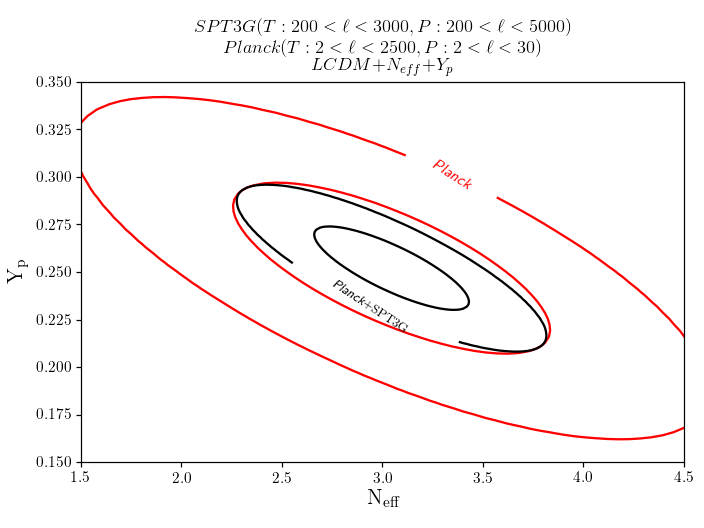

In [35]:
mu = [.252,3.046]
sigmap = Covp_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
sigmaps = Covps_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\rm{Y}_{\rm{p}}$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<2500,P:2<\ell<30)$'+ \
'\n $LCDM$+$N_{eff}$+$Y_p$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')
fmt1=dict(zip(cs1.levels,[r'$\textit{Planck}$+$\rm{SPT3G}$',r'$\textit{Planck}$+$\rm{SPT3G}$']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))

clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2, fontsize=10)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1, fontsize=8)
xlabel(xlab, fontsize=14)
ylabel(ylab, fontsize=14)
title(titl)
tight_layout()
xlim(1.5,4.5)
ylim(.15,.35)
savefig('Figures/Yp_Neff_constraints_planck_and_planckSPT3G.pdf')

In [36]:
Covp_800s_lcdm_neff_yp=pd.DataFrame(inv(Fp_800s_lcdm_neff_yp.as_matrix()),index=Fp_800s_lcdm_neff_yp.columns,
                               columns=Fp_800s_lcdm_neff_yp.columns)

<IPython.core.display.Javascript object>


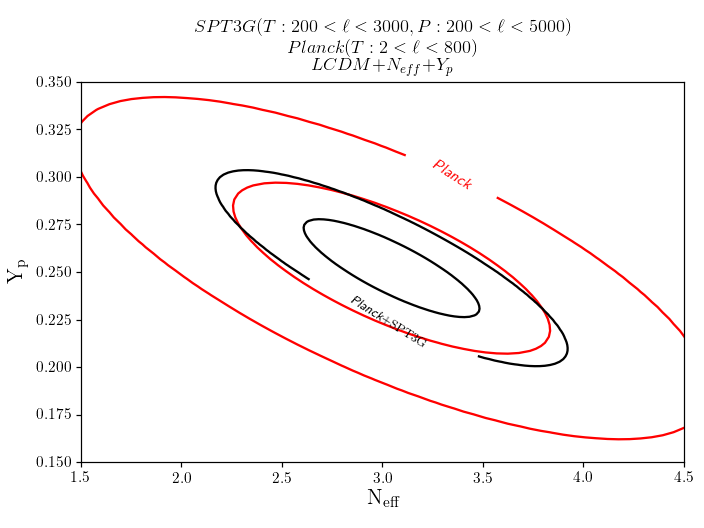

In [37]:
mu = [.252,3.046]
sigmap = Covp_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
sigmaps = Covp_800s_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\rm{Y}_{\rm{p}}$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<800)$'+ \
'\n $LCDM$+$N_{eff}$+$Y_p$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')
fmt1=dict(zip(cs1.levels,[r'$\textit{Planck}$+$\rm{SPT3G}$',r'$\textit{Planck}$+$\rm{SPT3G}$']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))

clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2, fontsize=10)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1, fontsize=8)
xlabel(xlab, fontsize=14)
ylabel(ylab, fontsize=14)
title(titl)
tight_layout()
xlim(1.5,4.5)
ylim(.15,.35)
savefig('Figures/Yp_Neff_constraints_planck_and_planck_800SPT3G.pdf')

In [38]:
Covs_lcdm_neff_yp=pd.DataFrame(inv(Fs_lcdm_neff_yp_lmin_100_700['200'].as_matrix()),
                               index=Fs_lcdm_neff_yp_lmin_100_700['200'].columns,
                               columns=Fs_lcdm_neff_yp_lmin_100_700['200'].columns)

<IPython.core.display.Javascript object>


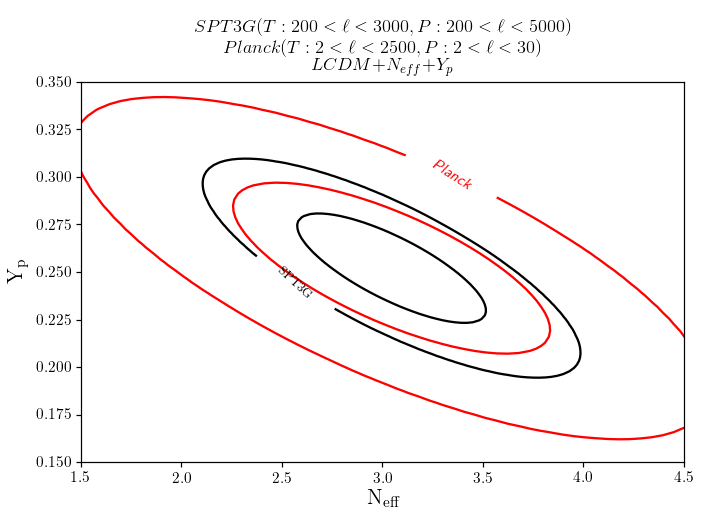

In [39]:
mu = [.252,3.046]
sigmap = Covp_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
sigmaps = Covs_lcdm_neff_yp[['YHe','nnu']].loc[['YHe','nnu']].as_matrix()
xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\rm{Y}_{\rm{p}}$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<2500,P:2<\ell<30)$'+ \
'\n $LCDM$+$N_{eff}$+$Y_p$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')
fmt1=dict(zip(cs1.levels,[r'$\rm{SPT3G}$',r'$\rm{SPT3G}$']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))

clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2, fontsize=10)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1, fontsize=8)
xlabel(xlab, fontsize=14)
ylabel(ylab, fontsize=14)
title(titl)
tight_layout()
xlim(1.5,4.5)
ylim(.15,.35)
savefig('Figures/Yp_Neff_constraints_planck_and_SPT3G.pdf')

In [40]:
params=Fs_lcdm_neff_yp_lmin_50_700['200'].columns[:-1]
fig, axes=subplots(len(params),3,figsize=(8,16),sharey='row')
lmins=sorted([int(l) for l in Fs_lcdm_neff_yp_lmin_50_700.keys()])
convert_names={'H0':'H0','YHe':'Yp','clamp':r'$A_se^{-2 \tau}$','nnu':'N_{eff}','ns':'n_s','ombh2':'$\Omega_bh^2$',
               'ommh2':'$\Omega_mh^2$'}
yscale={'H0':(.5,2.7),'YHe':(1.1,2.8),'clamp':(.5,2.2),'nnu':(1.5,2.6),'ns':(.5,2.3),'ombh2':(1.5,2.6),
        'ommh2':(.5,2.5)}
for i,p in enumerate(params):
    top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
    bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_yp_lmin_50_700[str(l)]+Fp_lcdm_neff_yp).as_matrix()),
                            index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
    axes[i,0].plot(lmins,top/bottom,color='r',label='LCDM+Neff+Yp')
    try:
        top = sqrt(Covp_lcdm_neff[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_lmin_50_700[str(l)]+Fp_lcdm_neff).as_matrix()),
                            index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
        axes[i,0].plot(lmins,top/bottom,color='g',label='LCDM+Neff')
    except KeyError:
        pass
    try:
        top = sqrt(Covp_lcdm[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_lmin_50_700[str(l)]+Fp_lcdm).as_matrix()),
                            index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
        axes[i,0].plot(lmins,top/bottom,color='k',label='LCDM')
    except KeyError:
        pass
    
    
#     top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
#     bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_yp_lmin_50_700[str(l)]+Fp_lcdm_neff_yp).as_matrix()),
#                             index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
#     axes[i,0].plot(lmins,top/bottom,'--r',label='LCDM+Neff+Yp')
#     try:
#         top = sqrt(Covp_lcdm_neff[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_lmin_50_700[str(l)]+Fp_lcdm_neff).as_matrix()),
#                             index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
#         axes[i,0].plot(lmins,top/bottom,'--g',label='LCDM+Neff')
#     except KeyError:
#         pass
#     try:
#         top = sqrt(Covp_lcdm[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_lmin_50_700[str(l)]+Fp_lcdm).as_matrix()),
#                             index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
#         axes[i,0].plot(lmins,top/bottom,'--k',label='LCDM')
#     except KeyError:
#         pass
    axes[i,0].set_xlabel('lmin')
    #axes[i,0].set_ylim(yscale[p])
    axes[i,0].set_ylabel('Planck $\sigma$/Planck+SPT3G $\sigma$')
    axes[i,0].set_title(convert_names[p])
    axes[i,0].set_xticks([50,100,300,500,700])
    
    

    top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
    bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_yp_lmin_50_700[str(l)]+Fp_800_lcdm_neff_yp).as_matrix()),
                            index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
    axes[i,1].plot(lmins,top/bottom,color='r',label='LCDM+Neff+Yp')
    try:
        top = sqrt(Covp_lcdm_neff[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_lmin_50_700[str(l)]+Fp_800_lcdm_neff).as_matrix()),
                            index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
        axes[i,1].plot(lmins,top/bottom,color='g',label='LCDM+Neff')
    except KeyError:
        pass
    try:
        top = sqrt(Covp_lcdm[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_lmin_50_700[str(l)]+Fp_800_lcdm).as_matrix()),
                            index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
        axes[i,1].plot(lmins,top/bottom,color='k',label='LCDM')
    except KeyError:
        pass
    
    
#     top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
#     bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_yp_lmin_50_700[str(l)]+Fp_800_lcdm_neff_yp).as_matrix()),
#                             index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
#     axes[i,1].plot(lmins,top/bottom,'--r',label='LCDM+Neff+Yp')
#     try:
#         top = sqrt(Covp_lcdm_neff[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_lmin_50_700[str(l)]+Fp_800_lcdm_neff).as_matrix()),
#                             index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
#         axes[i,1].plot(lmins,top/bottom,'--g',label='LCDM+Neff')
#     except KeyError:
#         pass
#     try:
#         top = sqrt(Covp_lcdm[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_lmin_50_700[str(l)]+Fp_800_lcdm).as_matrix()),
#                             index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
#         axes[i,1].plot(lmins,top/bottom,'--k',label='LCDM')
#     except KeyError:
#         pass
    axes[i,1].set_xlabel('lmin')
    #axes[i,1].set_ylim(yscale[p])
    axes[i,1].set_ylabel('Planck $\sigma$/Planck l<800+SPT3G $\sigma$')
    axes[i,1].set_title(convert_names[p])
    axes[i,1].set_xticks([50,100,300,500,700])



    top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
    bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_yp_lmin_50_700[str(l)]).as_matrix()),
                            index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
    axes[i,2].plot(lmins,top/bottom,'r',label='LCDM+Neff+Yp')
    try:
        top = sqrt(Covp_lcdm_neff[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_neff_lmin_50_700[str(l)]).as_matrix()),
                            index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
        axes[i,2].plot(lmins,top/bottom,'g',label='LCDM+Neff')
    except KeyError:
        pass
    try:
        top = sqrt(Covp_lcdm[p].loc[p])
        bottom = [sqrt(pd.DataFrame(inv((Fs_lcdm_lmin_50_700[str(l)]).as_matrix()),
                            index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
        axes[i,2].plot(lmins,top/bottom,'k',label='LCDM')
    except KeyError:
        pass
    
    
#     top = sqrt(Covp_lcdm_neff_yp[p].loc[p])
#     bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_yp_lmin_50_700[str(l)]).as_matrix()),
#                             index=Fp_lcdm_neff_yp.columns,columns=Fp_lcdm_neff_yp.columns)[p].loc[p]) for l in lmins]
#     axes[i,2].plot(lmins,top/bottom,'--r',label='LCDM+Neff+Yp')
#     try:
#         top = sqrt(Covp_lcdm_neff[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_neff_lmin_50_700[str(l)]).as_matrix()),
#                             index=Fp_lcdm_neff.columns,columns=Fp_lcdm_neff.columns)[p].loc[p]) for l in lmins]
#         axes[i,2].plot(lmins,top/bottom,'--g',label='LCDM+Neff')
#     except KeyError:
#         pass
#     try:
#         top = sqrt(Covp_lcdm[p].loc[p])
#         bottom = [sqrt(pd.DataFrame(inv((Fs_f035_lcdm_lmin_50_700[str(l)]).as_matrix()),
#                             index=Fp_lcdm.columns,columns=Fp_lcdm.columns)[p].loc[p]) for l in lmins]
#         axes[i,2].plot(lmins,top/bottom,'--k',label='LCDM')
#     except KeyError:
#         pass
    axes[i,2].set_xlabel('lmin')
    #axes[i,2].set_ylim(yscale[p])
    axes[i,2].set_ylabel('Planck $\sigma$/SPT3G $\sigma$')
    axes[i,2].set_title(convert_names[p])
    axes[i,2].set_xticks([50,100,300,500,700])
legend(loc=(-1.9,8.2))

tight_layout()
savefig('Figures/planckSPT3G_and_SPT3G_improvement_on_planck_params_vs_lmin_100_700.pdf')

<IPython.core.display.Javascript object>

NameError: name 'Covp_lcdm_neff' is not defined

## Compare SPT3G+Planck andSPTSZ+Planck

In [75]:
Covp_lcdm=pd.DataFrame(inv(Fp_lcdm.as_matrix()),index=Fp_lcdm.keys(),columns=Fp_lcdm.keys())

In [88]:
Covps_lcdm=pd.DataFrame(inv(Fps_lcdm.as_matrix()),index=Fp_lcdm.keys(),columns=Fp_lcdm.keys())

In [76]:
Covsz_lcdm=pd.DataFrame(inv(Fsz_lcdm.as_matrix()),index=Fsz_lcdm.keys(),columns=Fsz_lcdm.keys())

In [77]:
Covpsz_lcdm=pd.DataFrame(inv(Fpsz_lcdm.as_matrix()),index=Fpsz_lcdm.keys(),columns=Fpsz_lcdm.keys())

In [78]:
PSZ_params = dot(Fp_lcdm.as_matrix(),Planck_chain.mean(sorted(['H0','ombh2','ommh2','tau','clamp','ns'])))+\
dot(Fsz_lcdm.as_matrix(),SPTSZ_chain.mean(sorted(['H0','ombh2','ommh2','tau','clamp','ns'])))

PSZ_params=dict(zip(sorted(['H0','ombh2','ommh2','tau','clamp','ns']),dot(inv(Fpsz_lcdm.as_matrix()),PSZ_params)))


In [79]:
[PSZ_params]

[{'H0': 67.276313411149431,
  'clamp': 1.8879678210022242,
  'ns': 0.96471510949242312,
  'ombh2': 0.022177537742075815,
  'ommh2': 0.14193656735956073,
  'tau': 0.069367424802641686}]

<IPython.core.display.Javascript object>


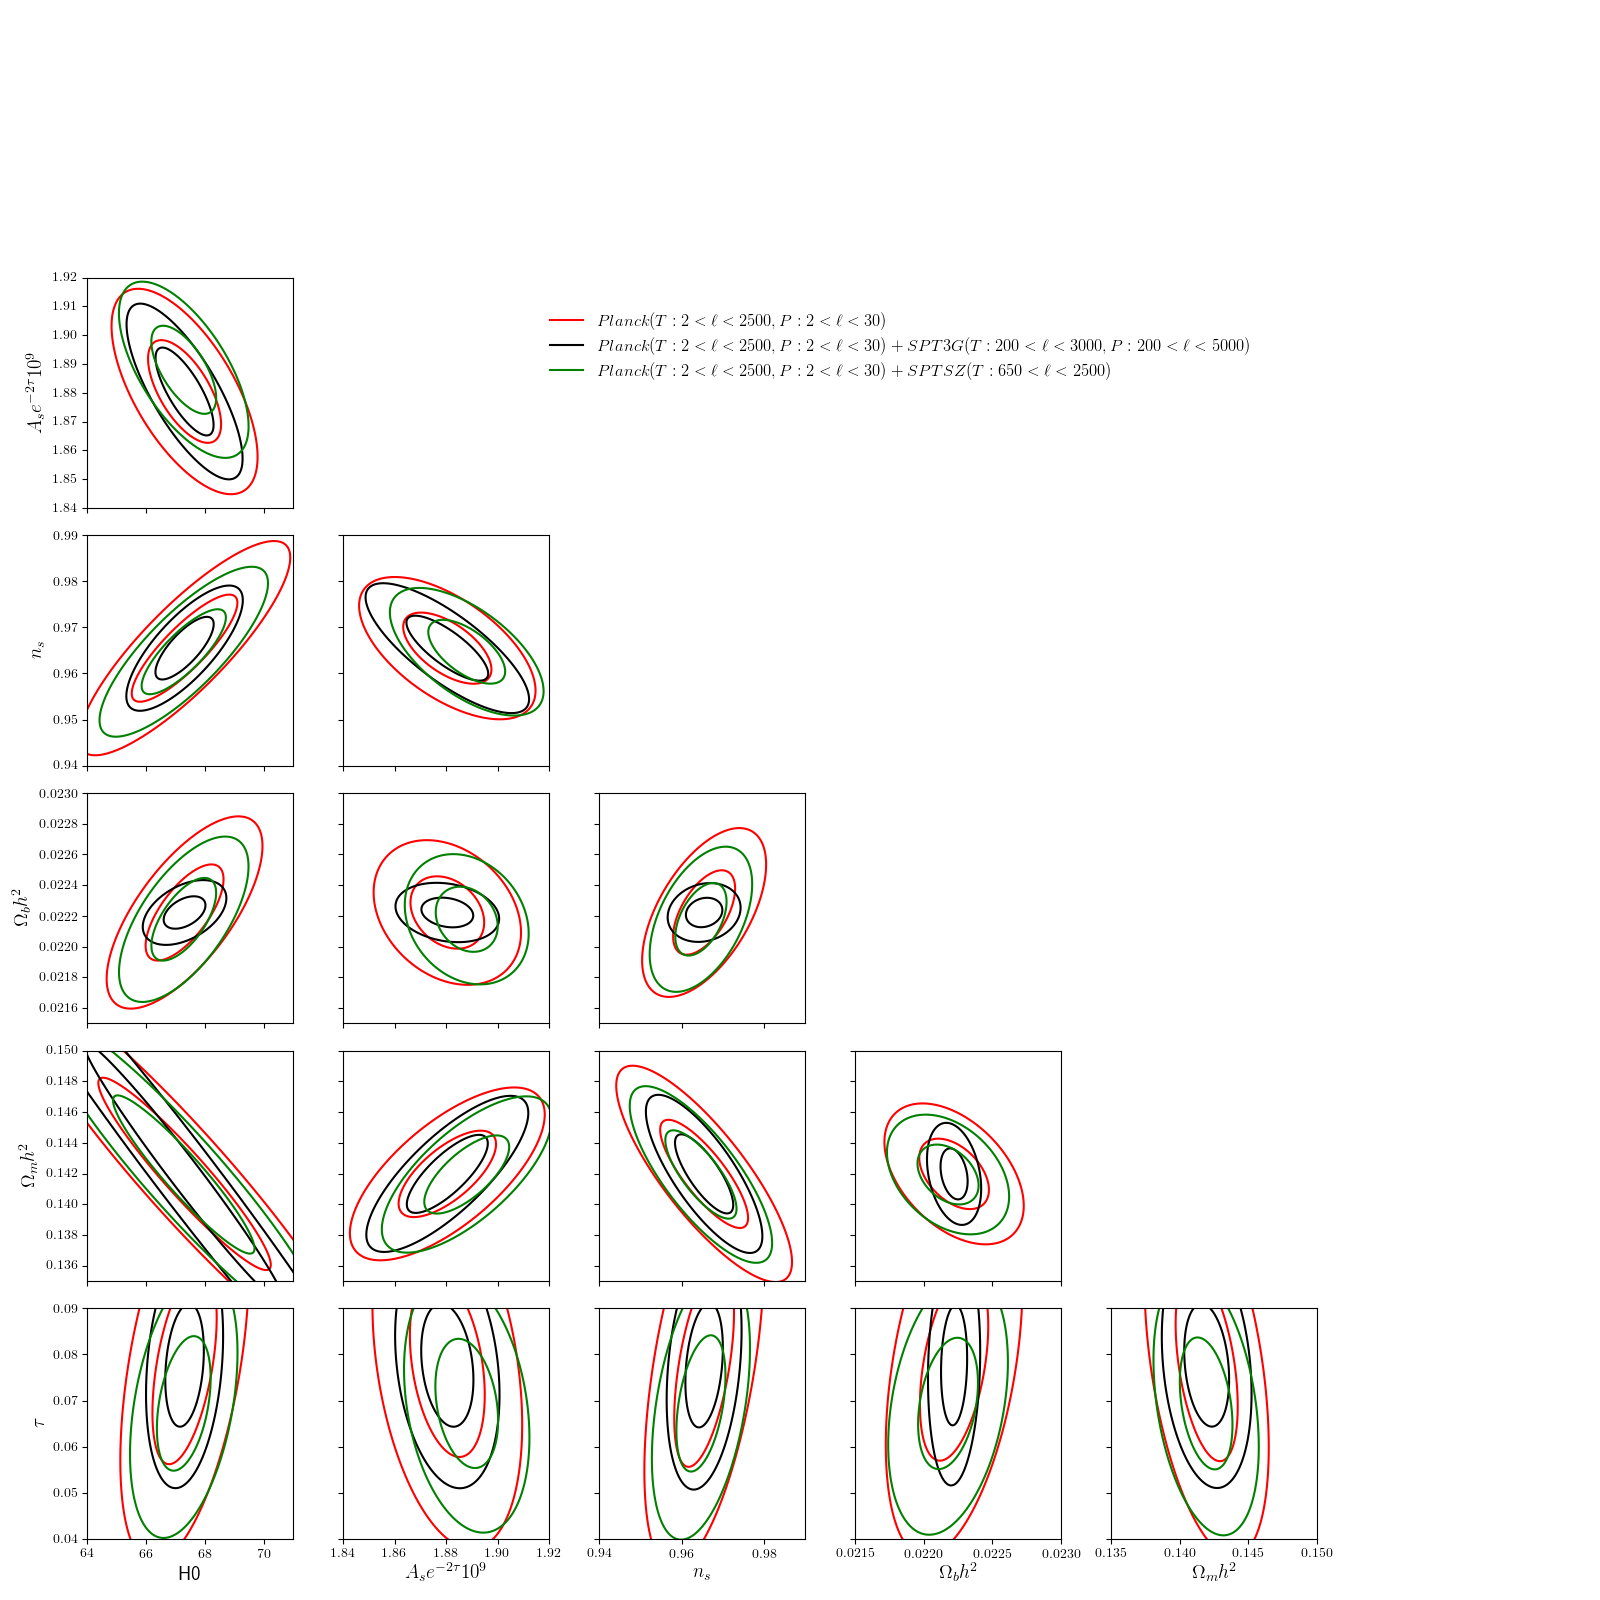

In [154]:
import matplotlib.lines as mlines
convert_names={'H0':'H0','clamp':r'$A_se^{-2 \tau}10^9$','ns':r'$n_s$','ombh2':'$\Omega_bh^2$',
               'ommh2':'$\Omega_mh^2$','tau':r'$\tau$'}
scale={'H0':(64,71),'clamp':(1.84,1.92),'ns':(.94,.99),'ombh2':(.0215,.023),
        'ommh2':(.135,.15),'tau':(.04,.09)}
params=Covp_lcdm.keys()
fig, axes=subplots(len(params),len(params),figsize=(16,16),sharey='row',sharex='col')

for i,p1 in enumerate(params):
    for j,p2 in enumerate(params):
        if i>j:
            sigmap = Covp_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            sigmaps = Covps_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            sigmapsz = Covpsz_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()

            matplotlib.rc('text', usetex = True)

            sig_contours(Planck_chain.mean([p1,p2]),sigmap,colors = 'r',ax=axes[i,j])
            sig_contours(Planck_chain.mean([p1,p2]),sigmaps,colors = 'k',ax=axes[i,j])
            sig_contours([PSZ_params[p1],PSZ_params[p2]],sigmapsz,colors = 'g',ax=axes[i,j])

            axes[-1,j].set_xlabel(convert_names[p2], fontsize=14)
            axes[i,0].set_ylabel(convert_names[p1], fontsize=14)
            axes[i,0].set_ylim(scale[p1])
            axes[-1,j].set_xlim(scale[p2])
        else:
            axes[i,j].axis('off')

a=mlines.Line2D([], [], color='r')
b=mlines.Line2D([], [], color='k')
c=mlines.Line2D([], [], color='g')

legend([a,b,c],[r'$Planck(T:2<\ell<2500,P:2<\ell<30)$',
                r'$Planck(T:2<\ell<2500,P:2<\ell<30)+SPT3G(T:200<\ell<3000,P:200<\ell<5000)$',
                r'$Planck(T:2<\ell<2500,P:2<\ell<30)+SPTSZ(T:650<\ell<2500)$'],loc = (-4,5),fontsize = 12,frameon=False)
tight_layout()
savefig('Figures/Param_constraints_planck_planckSPTSZ_planckSPT3G.pdf')

<IPython.core.display.Javascript object>


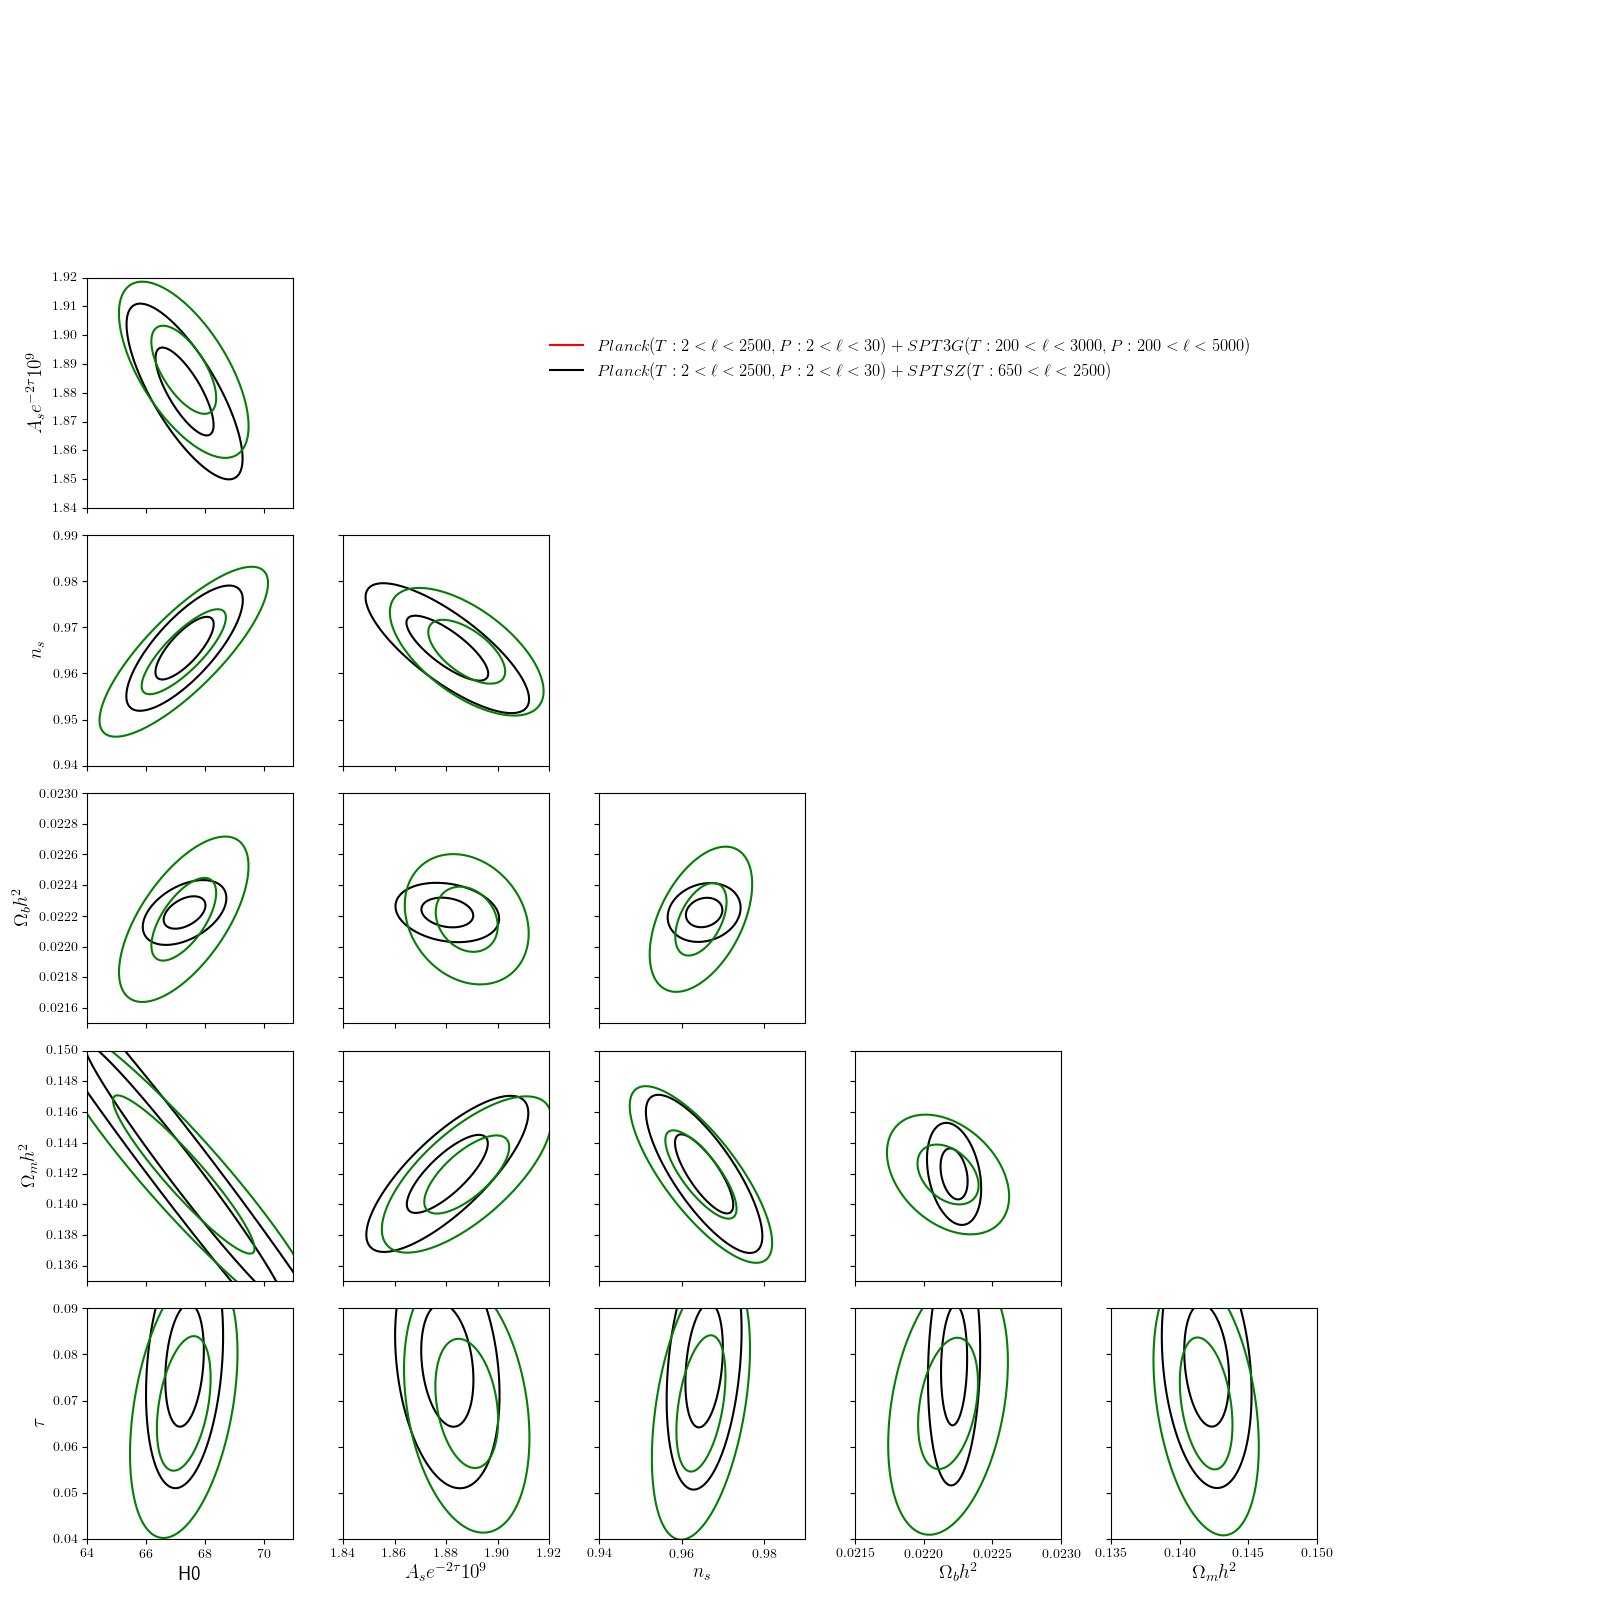

In [156]:
import matplotlib.lines as mlines
convert_names={'H0':'H0','clamp':r'$A_se^{-2 \tau}10^9$','ns':r'$n_s$','ombh2':'$\Omega_bh^2$',
               'ommh2':'$\Omega_mh^2$','tau':r'$\tau$'}
scale={'H0':(64,71),'clamp':(1.84,1.92),'ns':(.94,.99),'ombh2':(.0215,.023),
        'ommh2':(.135,.15),'tau':(.04,.09)}
params=Covp_lcdm.keys()
fig, axes=subplots(len(params),len(params),figsize=(16,16),sharey='row',sharex='col')

for i,p1 in enumerate(params):
    for j,p2 in enumerate(params):
        if i>j:
            #sigmap = Covp_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            sigmaps = Covps_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            sigmapsz = Covpsz_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()

            matplotlib.rc('text', usetex = True)

            #sig_contours(Planck_chain.mean([p1,p2]),sigmap,colors = 'r',ax=axes[i,j])
            sig_contours(Planck_chain.mean([p1,p2]),sigmaps,colors = 'k',ax=axes[i,j])
            sig_contours([PSZ_params[p1],PSZ_params[p2]],sigmapsz,colors = 'g',ax=axes[i,j])

            axes[-1,j].set_xlabel(convert_names[p2], fontsize=14)
            axes[i,0].set_ylabel(convert_names[p1], fontsize=14)
            axes[i,0].set_ylim(scale[p1])
            axes[-1,j].set_xlim(scale[p2])
        else:
            axes[i,j].axis('off')

#a=mlines.Line2D([], [], color='r')
b=mlines.Line2D([], [], color='k')
c=mlines.Line2D([], [], color='g')

legend([a,b,c],[r'$Planck(T:2<\ell<2500,P:2<\ell<30)+SPT3G(T:200<\ell<3000,P:200<\ell<5000)$',
                r'$Planck(T:2<\ell<2500,P:2<\ell<30)+SPTSZ(T:650<\ell<2500)$'],loc = (-4,5),fontsize = 12,frameon=False)
tight_layout()
savefig('Figures/Param_constraints_planckSPTSZ_planckSPT3G.pdf')

<IPython.core.display.Javascript object>


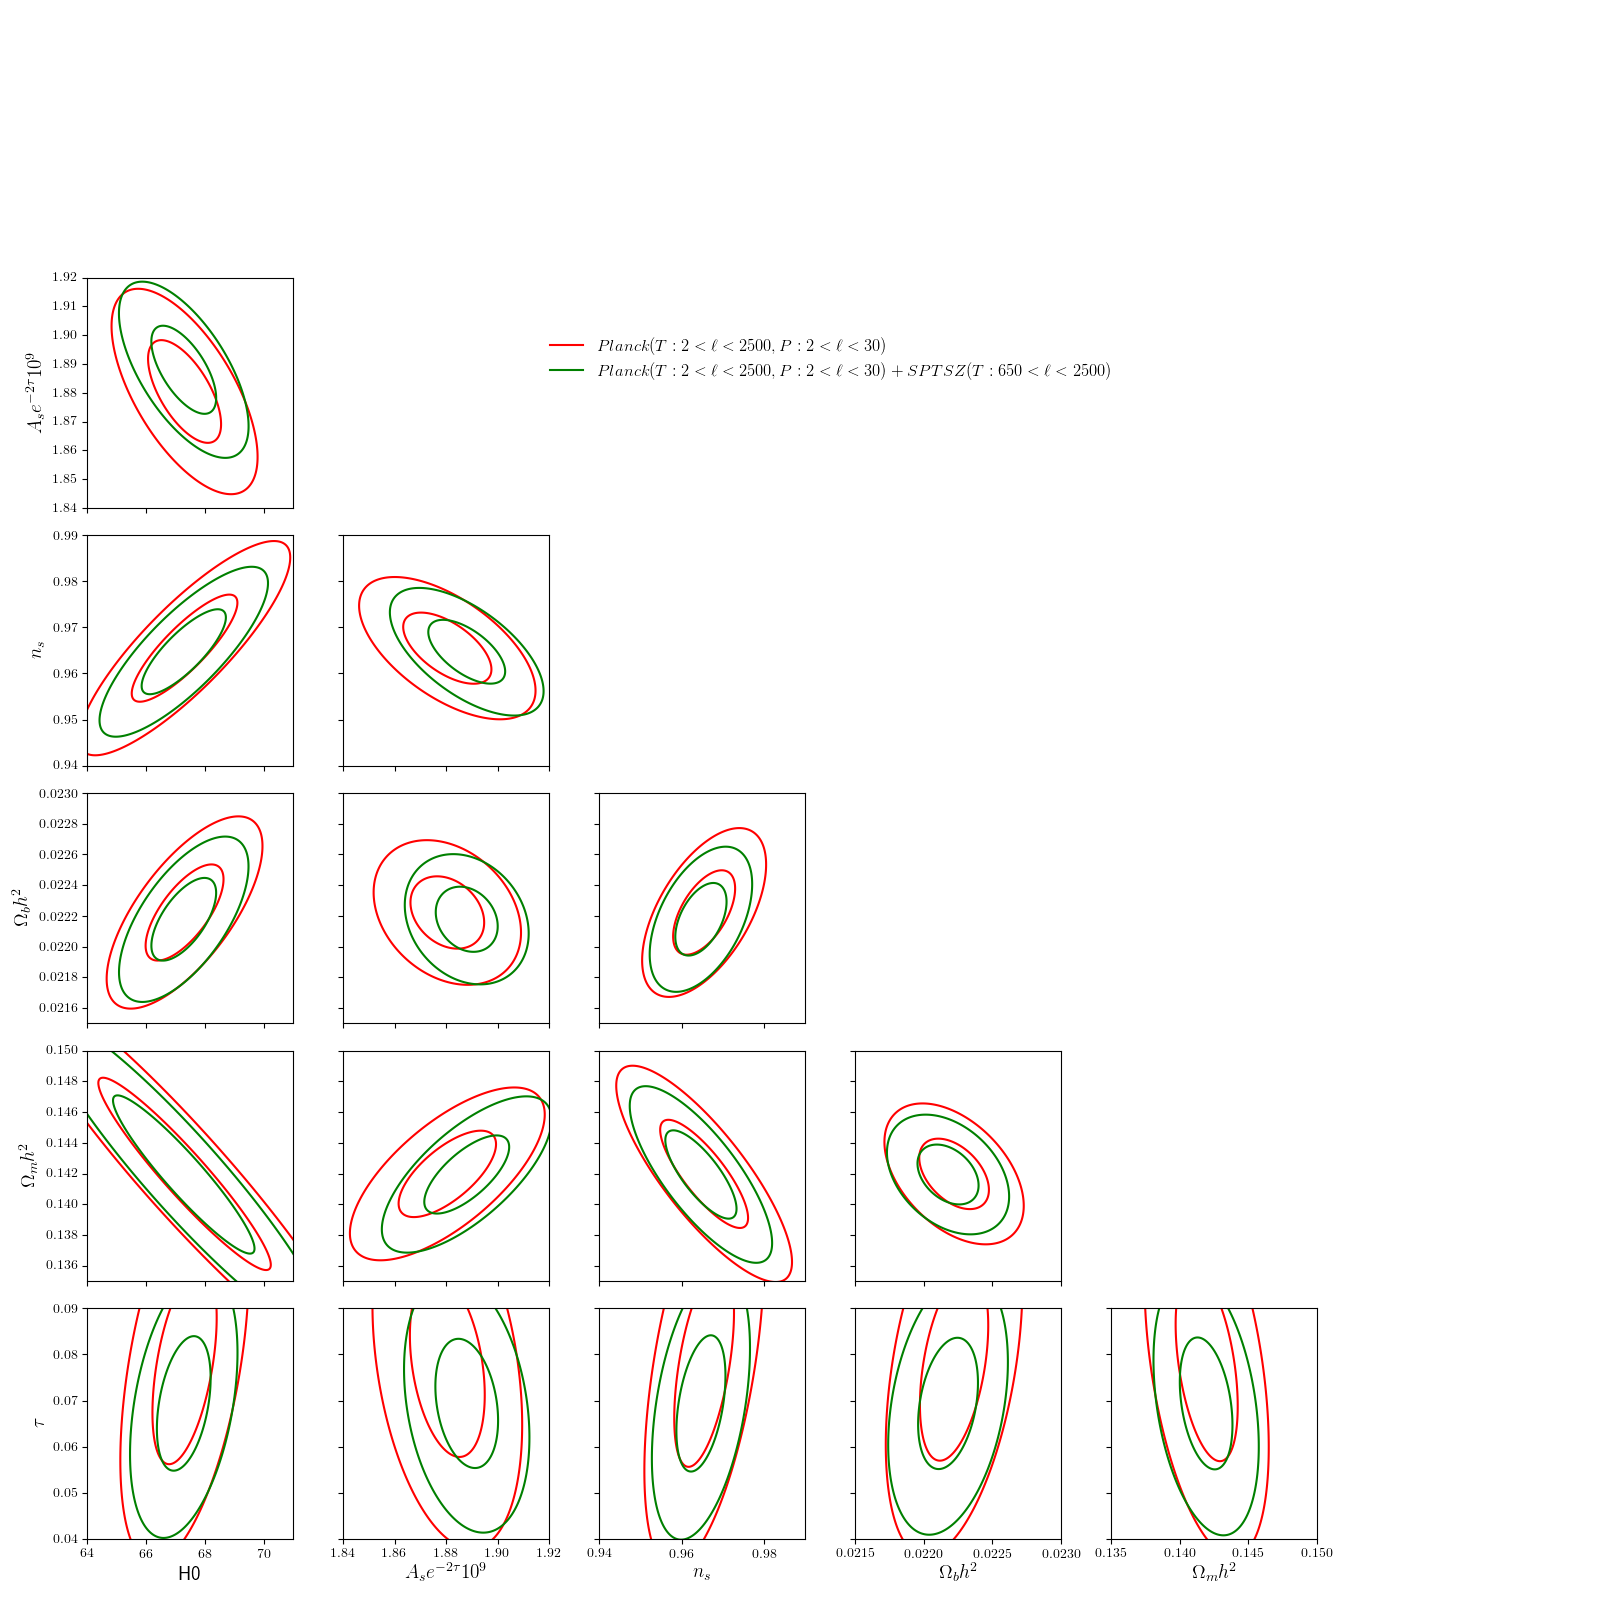

In [157]:
import matplotlib.lines as mlines
convert_names={'H0':'H0','clamp':r'$A_se^{-2 \tau}10^9$','ns':r'$n_s$','ombh2':'$\Omega_bh^2$',
               'ommh2':'$\Omega_mh^2$','tau':r'$\tau$'}
scale={'H0':(64,71),'clamp':(1.84,1.92),'ns':(.94,.99),'ombh2':(.0215,.023),
        'ommh2':(.135,.15),'tau':(.04,.09)}
params=Covp_lcdm.keys()
fig, axes=subplots(len(params),len(params),figsize=(16,16),sharey='row',sharex='col')

for i,p1 in enumerate(params):
    for j,p2 in enumerate(params):
        if i>j:
            sigmap = Covp_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            #sigmaps = Covps_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()
            sigmapsz = Covpsz_lcdm[[p1,p2]].loc[[p1,p2]].as_matrix()

            matplotlib.rc('text', usetex = True)

            sig_contours(Planck_chain.mean([p1,p2]),sigmap,colors = 'r',ax=axes[i,j])
            #sig_contours(Planck_chain.mean([p1,p2]),sigmaps,colors = 'k',ax=axes[i,j])
            sig_contours([PSZ_params[p1],PSZ_params[p2]],sigmapsz,colors = 'g',ax=axes[i,j])

            axes[-1,j].set_xlabel(convert_names[p2], fontsize=14)
            axes[i,0].set_ylabel(convert_names[p1], fontsize=14)
            axes[i,0].set_ylim(scale[p1])
            axes[-1,j].set_xlim(scale[p2])
        else:
            axes[i,j].axis('off')

a=mlines.Line2D([], [], color='r')
#b=mlines.Line2D([], [], color='k')
c=mlines.Line2D([], [], color='g')

legend([a,c],[r'$Planck(T:2<\ell<2500,P:2<\ell<30)$',
                
                r'$Planck(T:2<\ell<2500,P:2<\ell<30)+SPTSZ(T:650<\ell<2500)$'],loc = (-4,5),fontsize = 12,frameon=False)
tight_layout()
savefig('Figures/Param_constraints_planck_planckSPTSZ.pdf')